In [1]:
# import library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
Df= pd.read_csv('Churn_Modelling.csv')
Df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
# Feature Engineering
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
import category_encoders as ce
from sklearn.pipeline import Pipeline

# ML Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler  

# Model
import pickle
import joblib

import warnings
warnings.filterwarnings("ignore")

## A. EDA

In [4]:
# Proportion of not exited and exited
Df['Exited'].value_counts()/Df.shape[0]*100

0    79.63
1    20.37
Name: Exited, dtype: float64

### Jumlah nasabah tidak 'exited'/ memilih bertahan lebih besar (79.63 %) daripada yang pergi/exit.

In [5]:
Df['Gender'].value_counts()/Df.shape[0]*100

Male      54.57
Female    45.43
Name: Gender, dtype: float64

Text(0, 0.5, 'count')

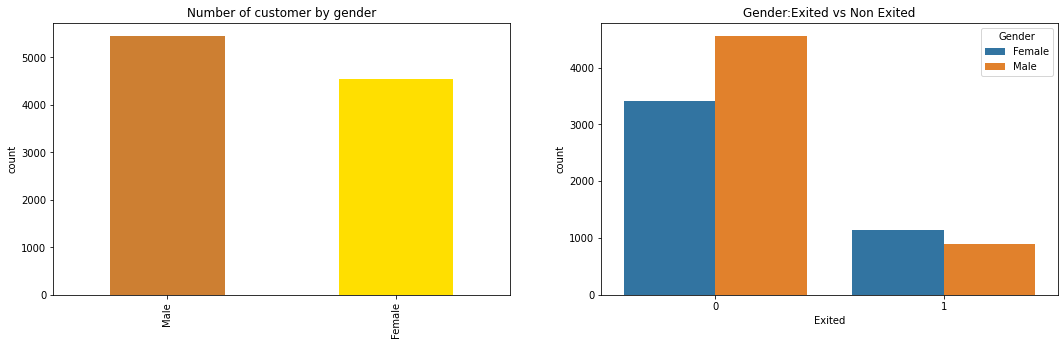

In [6]:
## Jumlah Nasabah berdasarkan Gender dan jumlah nasabah yang menutup akun bank nya
f,ax=plt.subplots(1,2,figsize=(18,5))
Df['Gender'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number of customer by gender')
ax[0].set_ylabel('count')
sns.countplot(data=Df,x='Exited',hue='Gender',ax=ax[1])
ax[1].set_title('Gender:Exited vs Non Exited')
ax[1].set_ylabel('count')

### 
- Proporsi jumlah nasabah bank dengan gender laki-laki lebih banyak dibandingkan perempuan. Lebih dari itu, nasabah yang memilih exited/pergi menutup akunnya jauh lebih sedikit dibanding nasabah yang stay (Mayoritas nasabah bertahan).
- Nasabah yang memilih pergi cenderung bergender perempuan, sementara yang stayed/bertahan cenderung bergender laki-laki.

Text(0, 0.5, 'percentage')

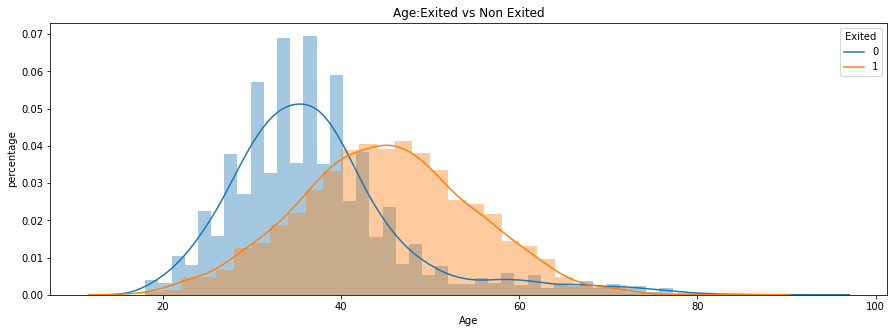

In [7]:
## Usia yang cenderung menutup akunnya dan pindah 
Non_Exited = Df[Df['Exited']==0]
Exited = Df[Df['Exited']==1]

plt.subplots(figsize=(15,5))
sns.distplot(Non_Exited['Age'])
sns.distplot(Exited['Age'])
plt.title('Age:Exited vs Non Exited')
plt.legend([0,1],title='Exited')
plt.ylabel('percentage')

### Umur nasabah yang memilih pergi/exit cenderung berusia diatas 40-45 tahun, sementara nasabah yang menetap berada di usia produktif, yaitu usia 30-35 tahun.

<AxesSubplot:xlabel='IsActiveMember', ylabel='Exited'>

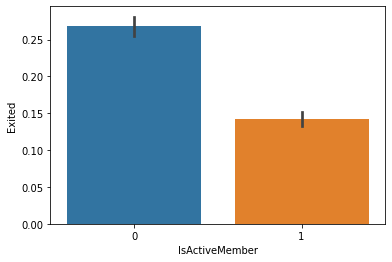

In [8]:
sns.barplot(x = Df['IsActiveMember'], y= Df['Exited'])
## jumlah member yang tidak aktif lebih banyak 

### Sementara dari semua nasabah yang memilih pergi, mayoritas bukan merupakan member yang masih aktif/ sudah jarang melakukan transaksi dengan bank yang bersangkutan.

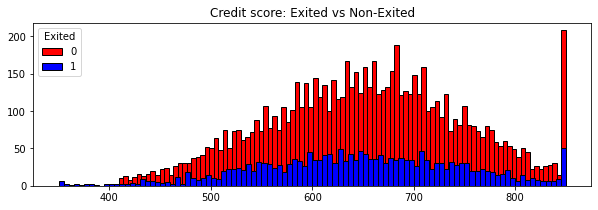

In [9]:
plt.figure(figsize=(10,3))
plt.hist(x='CreditScore',bins=100,data=Non_Exited,edgecolor='black',color='red')
plt.hist(x='CreditScore',bins=100,data=Exited,edgecolor='black',color='blue')
plt.title('Credit score: Exited vs Non-Exited')
plt.legend([0,1],title='Exited')

### Secara garis besar, dapat dikatakan bahwa nasabah yang tidak pernah menunggak/ selalu memenuhi kewajiban membayar cicilan kredit bank (high credit score) akan cenderung bertahan dan tidak menutup akunnya.

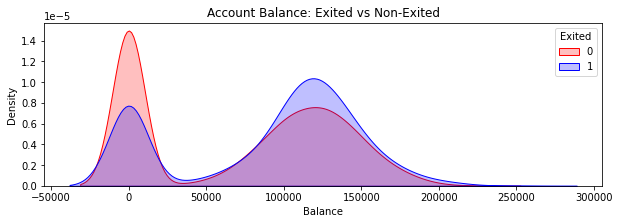

In [10]:
plt.figure(figsize=(10,3))
p1=sns.kdeplot(Non_Exited['Balance'], shade=True, color="r")
p1=sns.kdeplot(Exited['Balance'], shade=True, color="b");
plt.title('Account Balance: Exited vs Non-Exited')
plt.legend([0,1],title='Exited')

### Jika nasabah memiliki jumlah saldo yang banyak, mereka cenderung menjadi churn customers (tidak memakai dan tidak melakukan transaksi secara rutin) pada bank yang bersangkutan.

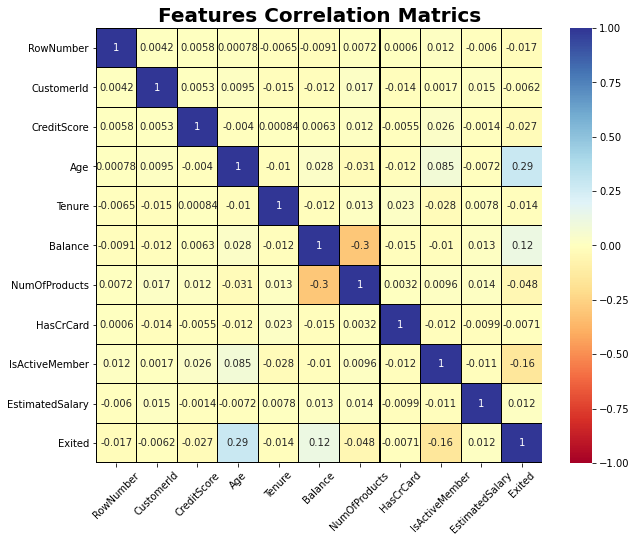

In [11]:
plt.title("features correlation matrics".title(),
          fontsize=20,weight="bold")

sns.heatmap(Df.corr(),annot=True,cmap='RdYlBu',linewidths=0.2, vmin=-1, vmax=1,linecolor = 'black') 
fig=plt.gcf()
plt.xticks(rotation = 45)
fig.set_size_inches(10,8)

### Dari data diatas, dapat dilihat bahwa feature yang memiliki korelasi tertinggi dengan fitur 'Exited' adalah 'Age', meskipun tingkat korelasi masih cenderung rendah/low correlation.

## B. Data Cleansing and Preprocessing

In [12]:
Df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Encoding scheme
###
 1   CustomerId  : pass      
 2   Surname     : Label Encoding     
 3   CreditScore : pass       
 4   Geography   : OneHot_fill     
 5   Gender      : OneHot      
 6   Age         : pass      
 7   Tenure      : pass       
 8   Balance     : pass      
 9   NumOfProducts : pass    
 10  HasCrCard   : pass      
 11  IsActiveMember : pass    
 12  EstimatedSalary : pass      

features yang harus di-encode terlebih ialah:

* Surname 
* Geography  
* Gender

In [37]:
Df.isna().sum()
# Tidak terdapat missing values pada Dataframe

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [28]:
# Encode features
Df['Surname'] = LabelEncoder.fit_transform(Df['Surname'])
Df['Geography'] = LabelEncoder.fit_transform(Df['Geography'])
Df['Gender'] = LabelEncoder.fit_transform(Df['Gender'])

In [29]:
#  Pipeline digunakan untuk menyatukan beberapa step sehingga Cross-Validation akan tetap bisa berjalan saat beberapa parameter diubah serta menghindari data/information leakage dan output diluar target processing.
from sklearn.impute import SimpleImputer

onehot_fill=Pipeline([
    ('fillna',SimpleImputer(strategy='most_frequent')),
    ('encode',OneHotEncoder(drop='first'))
])

transformer= ColumnTransformer([('one_hot',OneHotEncoder(drop='first'),['Gender']),
    ('onehot_fill', onehot_fill, ['Geography']) 
], remainder='passthrough')

In [30]:
transformer.transformers

[('one_hot', OneHotEncoder(drop='first'), ['Gender']),
 ('onehot_fill',
  Pipeline(steps=[('fillna', SimpleImputer(strategy='most_frequent')),
                  ('encode', OneHotEncoder(drop='first'))]),
  ['Geography'])]

In [60]:
transformer.fit_transform(Df)

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        1.0134888e+05, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 1.0000000e+00,
        1.1254258e+05, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.1393157e+05, 1.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        4.2085580e+04, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        9.2888520e+04, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        3.8190780e+04, 0.0000000e+00]])

### Data hasil encoding sudah berupa 0 dan 1.

## C. Model Benchmark & Evaluation Metric
### a). Pilihlah setidaknya 3 model machine learning yang Anda pahami untuk mendapatkan benchmark model ML untuk memprediksi apakah nasabah akan exit atau tidak!
### 
- Gunakan setidaknya satu ensemble model.
- Jelaskan secara singkat cara kerja model ML yang Anda gunakan!
### b). Metric evaluasi apa yang anda pilih guna mencegah nasabah menutup akun mereka? Jelaskan pilihan jawaban anda!

In [31]:
## DATA SPLITTING
X = Df.drop(columns = ['Exited'])
y = Df[['Exited']]

In [32]:
# Pertama-tama, akan dilakukan splitting data untuk mencegah adanya data leakage.
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.15)

In [33]:
x_train.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1867,1868,15740164,985,715,0,0,33,3,85227.84,1,1,1,68087.15
4849,4850,15660301,697,491,1,1,70,6,148745.92,2,1,1,17818.33
8817,8818,15570485,2674,558,2,1,40,4,161766.87,1,0,0,92378.54
8378,8379,15701319,187,614,1,0,37,6,96340.81,2,1,1,139377.24
660,661,15592937,1895,632,1,0,41,3,81877.38,1,1,1,33642.21


### selanjutnya akan dilakukan cross validation untuk memilih model benchmark.
### Digunakan 3 jenis model ML, yaitu:

1. Random Forest: model ini menggunakan basis decision tree dan termasuk ke dalam ensemble model. Model ini menggabungkan banyak decision tree ke dalam satu model dengan tujuan untuk meningkatkan akurasi prediksi

2. Logistic Regression: model yang menggunakan basis linear regression untuk mengatasi masalah klasifikasi. Bedanya, hasil perhitungan formulanya akan dimasukkan ke dalam interval kelas 0 dan 1.

3. Decision Tree: model yang bekerja dengan cara splitting node menjadi 2 atau lebih sub-nodes.

### 1. RANDOM FOREST CLASSIFIER

In [34]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
                'n_estimators':[5,7,10],
                'criterion':['gini','entropy'],
                'n_jobs':[-1], # -1 indicates the processing in parallel using all CPUs
                'max_features':['auto','log2',None] 
}

In [35]:
RFC_grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3)
RFC_grid.fit(x_train, y_train) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END criterion=gini, max_features=auto, n_estimators=5, n_jobs=-1; total time=   1.7s
[CV 2/5] END criterion=gini, max_features=auto, n_estimators=5, n_jobs=-1; total time=   0.8s
[CV 3/5] END criterion=gini, max_features=auto, n_estimators=5, n_jobs=-1; total time=   0.0s
[CV 4/5] END criterion=gini, max_features=auto, n_estimators=5, n_jobs=-1; total time=   0.0s
[CV 5/5] END criterion=gini, max_features=auto, n_estimators=5, n_jobs=-1; total time=   0.0s
[CV 1/5] END criterion=gini, max_features=auto, n_estimators=7, n_jobs=-1; total time=   0.0s
[CV 2/5] END criterion=gini, max_features=auto, n_estimators=7, n_jobs=-1; total time=   0.0s
[CV 3/5] END criterion=gini, max_features=auto, n_estimators=7, n_jobs=-1; total time=   0.0s
[CV 4/5] END criterion=gini, max_features=auto, n_estimators=7, n_jobs=-1; total time=   0.0s
[CV 5/5] END criterion=gini, max_features=auto, n_estimators=7, n_jobs=-1; total time=   0.0s

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'log2', None],
                         'n_estimators': [5, 7, 10], 'n_jobs': [-1]},
             verbose=3)

In [36]:
print(RFC_grid.best_params_) 
print(RFC_grid.best_estimator_)

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 10, 'n_jobs': -1}
RandomForestClassifier(criterion='entropy', n_estimators=10, n_jobs=-1)


In [37]:
RFC = RandomForestClassifier(n_estimators = RFC_grid.best_params_['n_estimators'],
                             criterion = RFC_grid.best_params_['criterion'],
                             max_features = RFC_grid.best_params_['max_features'],
                             n_jobs = RFC_grid.best_params_['n_jobs'])
RFC.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, n_jobs=-1)

In [38]:
RFC_y_pred = RFC.predict(x_test)
RFC_accuracy = accuracy_score(RFC_y_pred,y_test)
RFC_recall = recall_score(RFC_y_pred,y_test)
RFC_precision = precision_score(RFC_y_pred,y_test)
print(classification_report(RFC_y_pred,y_test))
print('Confusion Matrix:\n',confusion_matrix(RFC_y_pred,y_test))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1325
           1       0.42      0.72      0.53       175

    accuracy                           0.85      1500
   macro avg       0.69      0.79      0.72      1500
weighted avg       0.90      0.85      0.87      1500

Confusion Matrix:
 [[1151  174]
 [  49  126]]


In [ ]:
### DARI HASIL INI DAPAT DILIHAT BAHWA RECALL (FALSE NEGATIVE) ,MEMILIKI NILAI TERTINGGI DIBANDINGKAN PRECISION DAN F1-SCORE.
### Hal ini menyimpulkan bahwa model memprediksi customer tidak melakukan churn/exit dari bank bersangkutan, tapi realisasinya adalah customer melakukan pergi dan menutup akun. 

### 2. LOGISTIC REGRESSION

In [39]:
lr = LogisticRegression(random_state=10,max_iter=200)
lr.fit(x_train,y_train)

LogisticRegression(max_iter=200, random_state=10)

In [40]:
lr_y_pred = lr.predict(x_test)
lr_accuracy = accuracy_score(lr_y_pred,y_test)
lr_recall = recall_score(lr_y_pred,y_test)
lr_precision = precision_score(lr_y_pred,y_test)
print(classification_report(lr_y_pred,y_test))
print('Confusion Matrix:\n',confusion_matrix(lr_y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      1500
           1       0.00      0.00      0.00         0

    accuracy                           0.80      1500
   macro avg       0.50      0.40      0.44      1500
weighted avg       1.00      0.80      0.89      1500

Confusion Matrix:
 [[1200  300]
 [   0    0]]


### Berbeda dengan Random forest, logistic regression memiliki nilai precisi yang lebih baik dalam melihat False Postive. Namun tab model masih terus executing mesikpun telah dicoba beberapa parameter yang berbeda.

### 3. DECISION TREE CLASSIFIER

In [41]:
DTC = DecisionTreeClassifier(random_state=10)
DTC.fit(x_train,y_train)

DecisionTreeClassifier(random_state=10)

In [42]:
DTC_y_pred = DTC.predict(x_test)
DTC_accuracy = accuracy_score(DTC_y_pred,y_test)
DTC_recall = recall_score(DTC_y_pred,y_test)
DTC_precision = precision_score(DTC_y_pred,y_test)
print(classification_report(DTC_y_pred,y_test))
print('Confusion Matrix:\n',confusion_matrix(DTC_y_pred,y_test))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1175
           1       0.50      0.46      0.48       325

    accuracy                           0.78      1500
   macro avg       0.68      0.67      0.67      1500
weighted avg       0.78      0.78      0.78      1500

Confusion Matrix:
 [[1025  150]
 [ 175  150]]


## D. Model Improvement dan Hyper-parameter Tuning

In [46]:
model = RandomForestClassifier()

estimator_rf = Pipeline([('transformer', transformer), ('model', model)])
estimator_rf.fit(x_train, y_train)

y_pred = estimator_rf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1200
           1       0.79      0.46      0.58       300

    accuracy                           0.87      1500
   macro avg       0.84      0.71      0.75      1500
weighted avg       0.86      0.87      0.85      1500



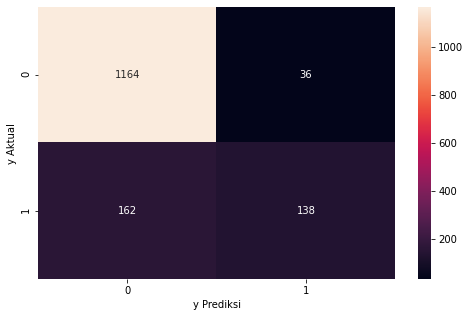

In [47]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.show()

In [48]:
hyperparam_space = {
        'model__n_estimators' : [50, 75, 100, 150],
        'model__min_samples_leaf' : [1, 5, 10, 15, 20, 50],
        'model__min_samples_split' : [2, 5, 10, 15, 20, 50],
        'model__max_depth' : [2, 3, 4, 5, 6, 7],
        'model__criterion' : ['entropy', 'gini']}

In [49]:

estimator = Pipeline([('preprocess', transformer), ('model', RandomForestClassifier())])
skfold = StratifiedKFold(n_splits=5)

grid = GridSearchCV(
    estimator, 
    param_grid = hyperparam_space, 
    cv = skfold, 
    scoring = 'f1')
    
grid.fit(x_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

### Model Evaluation

In [ ]:
# Evaluate the best estimator to the test data

grid.best_estimator_.fit(x_train, y_train)
f1_score(y_test, grid.best_estimator_.predict(x_test))

In [ ]:
y_pred = grid.best_estimator_.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred))
# saat ingin di run, proses running tidak berhenti berjalan sehingga hasil belum dapat keluar

In [ ]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual');

In [ ]:
# Save model

import pickle

estimator = Pipeline([('preprocess', transformer),('model', RandomForestClassifier())])
estimator.fit(X_train, y_train)

pickle.dump(estimator, open('Final_Model_Exam.sav', 'wb'))
## PROSES RUN PADA TAB SAVE MODEL BERHASIL DIJLANKAN, NAMUN ESTIMATOR TIDAK MENGELUARKAN OUTPUT APAPUN.

In [ ]:
# Save tuning result

import pickle

model_final = grid.best_estimator_.fit(X_train, y_train)

pickle.dump(model_final, open('Final_Tuning_Exam.sav', 'wb'))

In [ ]:
# load model
filename = 'Final_Model_Exam.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
loaded_model.predict(X_test)

In [ ]:
f1_score(y_test, loaded_model.predict(X_test))

## Kesimpulan:
### 
- Jenis kesalahan yang paling berpengaruh terhadap kerugian bank pada churn customers adalah False Negative (FN).
False Negative berarti model memprediksi customer tidak melakukan churn/exit dari bank bersangkutan, tapi realisasinya adalah customer melakukan pergi dan menutup akun. 
- Hal ini menjadi kerugian dikarenakan pihak bank tidak tahu nasabah mana yang meninggalkan bank tersebut dan traffic transaksi yang terus berkurang.
- Untuk mengatasi masalah tersebut, model machine learning bisa diimprovisasi hasilnya dengan cara meningkatkan nilai recall (menekan angka FN menjadi lebih sedikit).
- Model paling optimal yang dipilih untuk memprediksi apakah customer akan exit/menutup akun atau tidak pada kasus ini adalah model Random Forest Classifier karena memiliki nilai f1_score yang lebih baik dibandingkan model lain. Selain itu, setelah dilakukan hyperparameter tuning pun, model ini mampu mengurangi jumlah FN.